# Rachel Ward

## DAV 5400 - Project 1

For this project I will be utilizing a data set on flights out of Houston to answer research questions based on an invented business case.

This data comes from the [US Bureau of Transportation Statistics.](https://www.transtats.bts.gov/DatabaseInfo.asp?DB_ID=120&Link=0) A description of the dataset can be found [here.](https://cran.r-project.org/web/packages/hflights/hflights.pdf)

First I will import pandas and numpy. Next I will read the file into Jupyter by using the code provided in the assignment.

In [1]:
#first import pandas
import pandas as pd

#also import numpy, just in case
import numpy as np

#use the code provided in the assignment to read the file
filename = "https://raw.githubusercontent.com/jtopor/DAV-5400/master/Project1/hflights.csv"
flights = pd.read_csv(filename)

#use the head function to make sure the data loaded properly
flights.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,ArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted
0,2011,1,1,6,1400.0,1500.0,AA,428,N576AA,60.0,...,-10.0,0.0,IAH,DFW,224,7.0,13.0,0,NaN,0
1,2011,1,2,7,1401.0,1501.0,AA,428,N557AA,60.0,...,-9.0,1.0,IAH,DFW,224,6.0,9.0,0,NaN,0
2,2011,1,3,1,1352.0,1502.0,AA,428,N541AA,70.0,...,-8.0,-8.0,IAH,DFW,224,5.0,17.0,0,NaN,0
3,2011,1,4,2,1403.0,1513.0,AA,428,N403AA,70.0,...,3.0,3.0,IAH,DFW,224,9.0,22.0,0,NaN,0
4,2011,1,5,3,1405.0,1507.0,AA,428,N492AA,62.0,...,-3.0,5.0,IAH,DFW,224,9.0,9.0,0,NaN,0


### Task: Designate Research Questions

For this task, I chose to view this dataset from the perspective of a person who has just moved to Houston who is deciding which carrier's credit card they should join to maximize their points. Their apartment is equidistant from both airports, and they want to choose the carrier that is the most reliable and on time. For this reason I chose the following questions.

-  Which carrier had the shortest average arrival delay?
-  Which carrier had the shortest average departure delay?
-  Which carrier had the lowest percentage of cancelled flights?


### Preliminary Data Transformation

First I will limit the columns of the data set by creating a smaller data frame that only contains the information I need to answer my questions. This will also improve efficiency. Then I will check to see if there are any null values which could affect my results. 

#### Preliminary Data Transformation - Subset
Here I will limit the columns of the data set by creating a smaller data frame containing only the information I need. I have removed year and date information from this as all the data comes from the same year, 2011. 

In [2]:
#select a subset of the original flights dataframe
flights_sub = flights[['UniqueCarrier','ArrDelay','DepDelay','Cancelled']].copy()

#Check to make sure that the data I wanted pulled through correctly
flights_sub.head()

,UniqueCarrier,ArrDelay,DepDelay,Cancelled
0,AA,-10.0,0.0,0
1,AA,-9.0,1.0,0
2,AA,-8.0,-8.0,0
3,AA,3.0,3.0,0
4,AA,-3.0,5.0,0


#### Preliminary Data Transformation - NULL values
Next I will check to see if there are any null values present.

In [3]:
#See if there are any null values present as this will skew any results 
flights_sub.isnull().sum()

UniqueCarrier      0
ArrDelay         262
DepDelay         215
Cancelled          0
dtype: int64

In [4]:
#count number of rows so we will know how many rows we should have sincer there are nulls that need to be removed
x = flights_sub.shape[0]

#return results that are easy to reference later
print("The number of rows including nulls is", x)

The number of rows including nulls is 20000


### Data Transformation - Continued

Since there are null values for arrival delay and departure delay, we will need to remove the rows with null values. Our questions are regarding the mean arrival delay and departure delay, so these answers will both be affected if we leave the null values in there.  To accomplish this, I researched the dropna function which is explained well [here.](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html)

In [5]:
#create a copy of our dataframe from which we can remove the null values
flights_subnonulls = flights_sub.copy()

#drop rows where there are null values for arrival delay or departure delay
flights_subnonulls.dropna(subset=['ArrDelay','DepDelay'],inplace=True)

#check to see if this worked
flights_subnonulls.isnull().sum()


UniqueCarrier    0
ArrDelay         0
DepDelay         0
Cancelled        0
dtype: int64

Next I will check my row count to make sure that I only deleted the number of rows that I was expecting to delete given my earlier results.

In [6]:
#count the number of rows in our new data frame
y = flights_subnonulls.shape[0]

#print the results in a nice format
print("The number of rows in our new data frame is", y)

The number of rows in our new data frame is 19738


### Exploratory Data Analysis
Here I will perform explanatory data analysis on the new subset to see the distribution of arrival time delay, departure time delay, and cancelled flights amongst the different carriers. 

#### Exploratory Data Analysis - Arrival Time Delay

First I will look at arrival time delay across carriers. 

In [7]:
#show the mean, standard deviation, minimum, and quartiles for arrival delay across all flights with no null values
flights_subnonulls['ArrDelay'].describe()

count    19738.000000
mean         5.205340
std         25.383494
min        -49.000000
25%         -8.000000
50%          0.000000
75%         11.000000
max        775.000000
Name: ArrDelay, dtype: float64

In [8]:
ArrDelayHist = flights_subnonulls['ArrDelay'].plot(kind='hist')
ArrDelayHist;

The above histogram and descriptive statistics show that the overall distribution of arrival time delay is skewed to the right, with a mean of 5.2 minutes, a minimum of -49 minutes (or 49 minutes early), and a max of 775. The histogram indicates that the average arrival delay is very small and that there are many outliers, since three standard deviations above the mean is roughly 82 minutes delayed. Anything past 82 minutes could be considered an outlier. 

Next we will examine if this trend is present when spread amongst carriers to determine which carrier has the lowest average arrival delay. To do so I will first create a new data frame that only contains the mean of each unique carrier so that we can transform that data into a visualization. 

In [9]:
#Create a new Data Frame with the unique carriers and the mean of their arrival time
ArrDelayFrame = flights_subnonulls.groupby('UniqueCarrier',as_index=False)['ArrDelay'].mean()

#Display results
ArrDelayFrame

,UniqueCarrier,ArrDelay
0,AA,0.950397
1,AS,9.396552
2,B6,11.086022
3,CO,5.366780
4,DL,4.310924
5,EV,13.927083
6,F9,13.725806
7,FL,1.624060
8,MQ,7.144615
9,OO,5.743106


Now that we have the data frame created which contains only average arrival delay per carrier, I will create the visualization.

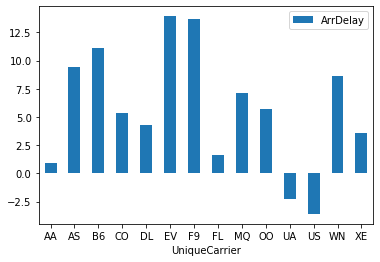

In [10]:
#graph a bar chart showing this data in a visualization
ArrDelaybarchart = ArrDelayFrame.plot.bar(x='UniqueCarrier', y ='ArrDelay',rot=0)

#return the results without the autogenerated code
ArrDelaybarchart;

The above bar chart indicates that two of the carriers, UA and US, arrive early on average, with US having the smallest average arrival delay. It also shows that there are five carriers who have an average arrival delay that is *greater* than the average arrival delay of the entire distribution. 

#### Exploratory Data Analysis - Departure Delays

Here I will look at the distribution of departure delays across carriers. 

In [11]:
#find the mean, standard deviation, and quartiles for departure delay across all flights
flights_subnonulls.describe()['DepDelay']

count    19738.000000
mean         8.271253
std         23.861301
min        -18.000000
25%         -3.000000
50%          1.000000
75%         10.000000
max        780.000000
Name: DepDelay, dtype: float64

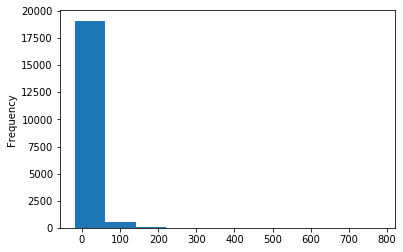

In [12]:
#Create a histogram to display the departure delay distribution
depdelaybar = flights_subnonulls['DepDelay'].plot(kind='hist')

#Return the results without the autogenerated code
depdelaybar;

The descriptive statistics above and the histogram show that the average departure delay is roughly 8 minutes, with a minimum of 18 minutes early and a maximum of 780 minutes. The standard deviation of the distribution is 23 minutes. The histogram also shows us that, like arrival delay, departure delay is also skewed right. The maximum of 780 tells us that there are definitely outliers because the 75th percentile is 10, and 3 standard deviations above the mean would be 77.

Next I will look at the distribution among carriers.  To do so I will first create a separate dataframe which contains only information about the average departure delay for each carrier. 

In [13]:
#Create a new DataFrame with the mean departure delay per carrier
DepDelayFrame = flights_subnonulls.groupby('UniqueCarrier',as_index=False)['DepDelay'].mean()

#Display results
DepDelayFrame

,UniqueCarrier,DepDelay
0,AA,5.630952
1,AS,4.724138
2,B6,18.344086
3,CO,9.859613
4,DL,8.033613
5,EV,21.062500
6,F9,6.306452
7,FL,3.939850
8,MQ,9.901538
9,OO,6.738752


Next I will create a bar chart for average departure delay per carrier.

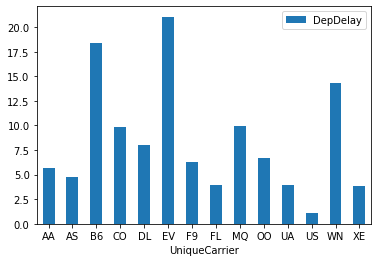

In [14]:
#graph a bar chart showing this data in a visualization
DepDelaybarchart = DepDelayFrame.plot.bar(x='UniqueCarrier', y ='DepDelay',rot=0)

#return the results without the autogenerated code
DepDelaybarchart;

The above bar chart shows us that the carrier with the shortest average departure delay is US. We also see that there are five carriers with an average departure delay greater than the mean for all flights. 

#### Exploratory Data Analysis - Arrival Delay & Departure Delay side by side
Because it is possible for a carrier to have a great arrival delay record but a poor departure delay record or vice versa, it would be helpful to compare these two metrics side by side. That is what I will explore here. I will first create another dataframe by concatenating two previously created dataframes on average arrival delay and average departure delay, and by creating a third dataframe with just the unique carrier names.

In [15]:
#First we need to get the unique carriers which we can do by slicing either of the frames we previously created
Carriers = DepDelayFrame['UniqueCarrier']

#Next I will get the mean Arrival Delay by slicing the ArrDelay Frame created earlier
AvgArrivalDelay = ArrDelayFrame['ArrDelay']

#Then I get the mean Departure Delay by slicing the DepDelay Frame created earlier
AvgDepartureDelay = DepDelayFrame['DepDelay']

#Lastly I create a combined frame using pandas concat function, concatenating by columns
CombinedFrame = pd.concat([Carriers,AvgArrivalDelay,AvgDepartureDelay],1)

#Display results to check for accuracy
CombinedFrame

,UniqueCarrier,ArrDelay,DepDelay
0,AA,0.950397,5.630952
1,AS,9.396552,4.724138
2,B6,11.086022,18.344086
3,CO,5.366780,9.859613
4,DL,4.310924,8.033613
5,EV,13.927083,21.062500
6,F9,13.725806,6.306452
7,FL,1.624060,3.939850
8,MQ,7.144615,9.901538
9,OO,5.743106,6.738752


Now that we have a combined data set by average we can graph the results using a side by side bar chart. 

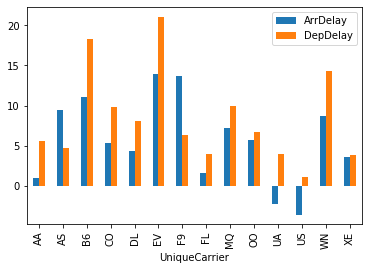

In [16]:
#Create the bar chart with Carrier on the x axis
Combinedbar= CombinedFrame.plot.bar(x='UniqueCarrier')

#Return the chart without the autogenerated code
Combinedbar;

We see from the chart above that the carrier US has the smallest average arrival delay and departure delay. Other carriers that are below the mean for both variables (8.271253 for departure delay and 5.205340 for arrival delay) are AA, FL, DL, OO, UA, and XE. Since we are looking for reliable carriers, and the shorter the delay time means a more reliable carrier, we ideally want to choose a carrier who has a shorter than average delay time for both arrival and departure.

#### Exploratory Data Analysis - Cancelled Flights

Next I will look at the percentage of cancelled flights by carrier. To do so I will need to use the original data subset because the flights removed in the previous part of my exploratory analysis were possibly lacking arrival and departure delay times because they were cancelled. I will create data frames for sum(since cancelled flights have an indicator of 1 the sum will tell me how many cancelled flights there were) and count (to get the total number of flights for that carrier) so that I can create a calculated percentage column for each carrier. I am not concerned with null values here because in the data transformation stage above I saw that there were no null values in the cancelled column.

In [17]:
#First create the data frame of unique carriers
CancelledCarriers = DepDelayFrame['UniqueCarrier']

#Next create the data frame of count of flights to get the total number of flights for that carrier
CountCancelledFrame = flights_sub.groupby('UniqueCarrier',as_index=False)['Cancelled'].count()

#Now rename the column to clarify what it is so when we join the frames we won't have multiple columns named Cancelled
CountCancelledFrame.rename(columns={'Cancelled': 'CountOfFlights'},inplace=True)

#Next create the data frame of sum to get the total number of cancelled flights for each carrier
SumCancelledFrame = flights_sub.groupby('UniqueCarrier',as_index=False)['Cancelled'].sum()

#Now rename the column to clarify what it is so when we join the frames we won't have multiple columns named Cancelled
SumCancelledFrame.rename(columns={'Cancelled':'SumOfCancelled'},inplace=True)

#Combine the above data frames into one new data frame
CombinedCancelledFrame = pd.concat([CancelledCarriers,CountCancelledFrame['CountOfFlights'],SumCancelledFrame['SumOfCancelled']],1)

#Create the calculated column of percent of cancelled flights
CombinedCancelledFrame['PercentCancelled']=(CombinedCancelledFrame['SumOfCancelled']/CombinedCancelledFrame['CountOfFlights'])*100

#Return the new data frame to check results
CombinedCancelledFrame

,UniqueCarrier,CountOfFlights,SumOfCancelled,PercentCancelled
0,AA,519,14,2.697495
1,AS,59,0,0.000000
2,B6,100,6,6.000000
3,CO,6830,53,0.775988
4,DL,258,20,7.751938
5,EV,106,9,8.490566
6,F9,62,0,0.000000
7,FL,144,11,7.638889
8,MQ,331,6,1.812689
9,OO,699,7,1.001431


Now that we have properly created the data frame, we can gather descriptive statistics on the percentage of cancelled flights.

In [18]:
#Get descriptive statistics on percentage of flights cancelled across all carriers.
CombinedCancelledFrame.describe()['PercentCancelled']

count    14.000000
mean      3.149455
std       3.047028
min       0.000000
25%       0.831452
50%       2.255092
75%       5.311688
max       8.490566
Name: PercentCancelled, dtype: float64

Next I will create a box and whisker plot to display these statistics in a visualization so that we can quickly identify the shape of the distribution.

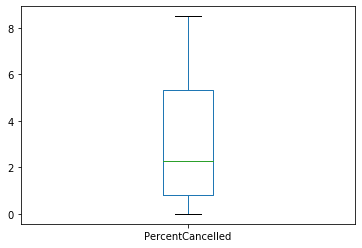

In [19]:
#graph a box and whisker plot showing this data in a visualization
Cancelledbox = CombinedCancelledFrame.plot.box(x='UniqueCarrier', y ='PercentCancelled',rot=0)

#return the results without the autogenerated code
Cancelledbox;

We can see from the descriptive statistics that the distribution of percentage of cancelled flights per carrier is skewed right with a mean of 3.15%, a minimum of 0%, a max of 8.5%, and a standard deviation of 3.05. Based on this information as well as the box and whisker plot, there do not appear to be any outliers.

Lastly I will create a bar chart so we can see the percentage of cancelled flights per carrier.

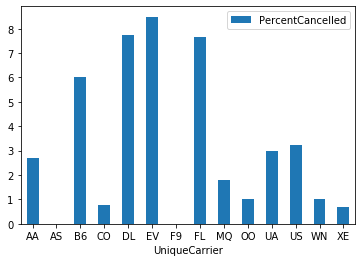

In [20]:
#graph a bar chart showing the percentage of cancelled flights per carrier in a visualization
Cancelledbar = CombinedCancelledFrame.plot.bar(x='UniqueCarrier', y ='PercentCancelled',rot=0)

#return the results without the autogenerated code
Cancelledbar;

This chart shows us that there are ten carriers with a percentage of cancelled flights below the mean of 3.15%. The carriers AS and F9 have 0% cancelled flights. The carrier EV has the highest percentage of cancelled flights at over 8%.

### Research Questions - Answers
As stated above my three questions were:
- Which carrier had the shortest average arrival delay?
- Which carrier had the shortest average departure delay?
- Which carrier had the lowest percentage of cancelled flights?

I will now take the information learned through my exploratory data analysis and answer these three questions. 


#### Which carrier had the shortest average arrival delay?

Referencing the bar graph in cell 10 about average arrival delay, the carrier with the shortest average arrival delay is US. There were also five other airlines whose average arrival delay is less than the mean of 5 minutes, AA, DL, FL, UA and XE.

#### Which carrier had the shortest average departure delay?

Referencing the bar graph in cell 14, we can see that the carrier with the shortest average departure delay is US. There are 8 other carriers with an average departure delay less than the mean: AA, AS, DL, F9, FL, OO, UA, and XE. 


#### Which carrier had the lowest percentage of cancelled flights?

Referencing the bar graph generated by cell 20, we see that carriers AS and F9 had 0% of their flights cancelled. However, if we look further at the data, we can see that each of those carriers took less than 100 flights total.  When compared to carriers like CO and XE which took over 6000 flights, and still had less than 1% of total flights cancelled, the 0% of cancelled flights for AS and F9 seems less impressive. 

### Conclusion

The overall goal of this research was to determine which carrier's credit card a recent Houston transplant should get based on reliability and timeliness of the carrier. Based on the three criteria above, I would recommend carrier XE. Although there are four carriers (AA, OO, UA, and XE) which scored below the mean for average arrival delay, average departure delay, and percentage of cancelled flights, XE had a much larger sample size at over 6000 flights. Since the sample size for this carrier was much larger than the sample size of the other carriers who fit this criteria, it indicates to me that XE is the most reliable carrier. 